# Wine Reviews


Планируется создать прогностическую модель для идентификации вин с помощью слепой дегустации, как это сделал бы мастер-сомелье.  Планируется использовать глубокое обучение, чтобы предсказать сорт вина, используя слова в описании / обзоре. Модель по-прежнему не сможет попробовать вино, но теоретически она может идентифицировать вино на основе описания, которое может дать сомелье.

Данные были получены от Wine Enthusiast в течение недели с 15 июня 2017 года.

# Общая цель -
Cоздать модель, которая может идентифицировать сорт, винодельню и местоположение вина на основе описания.

# 1. Data analaysis 
Изучим наш набор данных и взглянем на наши функции.



In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

print(os.listdir("../input"))


['winemag-data_first150k.csv', 'winemag-data-130k-v2.json', 'winemag-data-130k-v2.csv']


In [2]:
data=pd.read_csv('../input/winemag-data-130k-v2.csv')
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


Мы видим, что есть столбец с именем 'Unnamed: 0', который содержит идентификаторы каждого вина. Идентификаторы не могут помочь нам в регрессии, поэтому мы должны удалить этот столбец. Мы также опустим столбец описания.

In [3]:
data=data.drop(columns=['Unnamed: 0', 'description'])
data=data.reset_index(drop=True)

Теперь изучим наши возможности более статистически.
Мы будем использовать метод описания от pandas.
Это вернет нам информацию о:
* значении
* стандартном отклонении
* минимальном значении
* максимальном значении

In [4]:
data.describe()

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


Как мы можем видеть, только цена является непрерывной переменной в наших входных данных. Как мы можем видеть по минимальному и максимальному значению, существует действительно большое разнообразие ценовых характеристик. Есть вино, которое стоит 3300 долларов, но мы видим, что 75 процентов вин дешевле 42 долларов.

###  Дубликаты.
Прежде всего, давайте изучим наши данные. При первом просмотре данных мы видим, что существует много дубликатов, которые мы должны удалить.

Давайте посмотрим, сколько дубликатов содержится в данных.

In [5]:
print("Total number of examples: ", data.shape[0])
print("Number of examples with the same title and description: ", data[data.duplicated(['description','title'])].shape[0])

Total number of examples:  129971
Number of examples with the same title and description:  11131


Мы видим, что существует почти 10 тысяч записей с одинаковым названием и описанием. Мы должны отбросить их, чтобы получить правильный результат.

In [6]:
data=data.drop_duplicates(['description','title'])
data=data.reset_index(drop=True)

Теперь исследуем наш набор данных, чтобы увидеть, сколько в нем недостающих значений.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118840 entries, 0 to 118839
Data columns (total 12 columns):
country                  118781 non-null object
designation              84551 non-null object
points                   118840 non-null int64
price                    110581 non-null float64
province                 118781 non-null object
region_1                 99346 non-null object
region_2                 46568 non-null object
taster_name              94107 non-null object
taster_twitter_handle    89587 non-null object
title                    118840 non-null object
variety                  118839 non-null object
winery                   118840 non-null object
dtypes: float64(1), int64(1), object(10)
memory usage: 10.9+ MB


Мы видим, что существует огромное количество недостающих значений. Давайте посмотрим, сколько процентов.

In [8]:
total = data.isnull().sum().sort_values(ascending = False)
percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
region_2,72272,60.814541
designation,34289,28.853080
taster_twitter_handle,29253,24.615449
taster_name,24733,20.812016
region_1,19494,16.403568
price,8259,6.949680
province,59,0.049647
country,59,0.049647
variety,1,0.000841
winery,0,0.000000


Больше всего недостающих значений содержится в столбцах регион, пункт назначения, название тестера и цена.

Больше всего смущают вина с NaN в колонках цен. Мы не хотим прогнозировать баллы за вина, цена которых не объявлена. Мы отбросим строки со значением NaN в этом столбце.

In [9]:
data=data.dropna(subset=['price'])
data=data.reset_index(drop=True)

Давайте также кратко взглянем на самые дорогие вина.

In [10]:
data[(data['price'] > 2200)]

,country,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
14609,France,NaN,96,2500.0,Bordeaux,Pomerol,NaN,Roger Voss,@vossroger,Château Pétrus 2014 Pomerol,Bordeaux-style Red Blend,Château Pétrus
70456,France,NaN,88,3300.0,Bordeaux,Médoc,NaN,Roger Voss,@vossroger,Château les Ormes Sorbet 2013 Médoc,Bordeaux-style Red Blend,Château les Ormes Sorbet
85440,France,NaN,96,2500.0,Burgundy,La Romanée,NaN,Roger Voss,@vossroger,Domaine du Comte Liger-Belair 2010 La Romanée,Pinot Noir,Domaine du Comte Liger-Belair


Все 3 самых дорогих вина родом из Франции.

# Визуализация данных
Помните, что на этом этапе наша цель - не только изучить наши данные, чтобы получить более точные прогнозы. Мы также хотим лучше понять, что содержится в самих данных

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

def pastel_plot(data, x, y):
    plt.figure(figsize = (15,6))
    plt.title('Points histogram - whole dataset')
    sns.set_color_codes("pastel")
    sns.barplot(x = x, y=y, data=df)
    locs, labels = plt.xticks()
    plt.show()

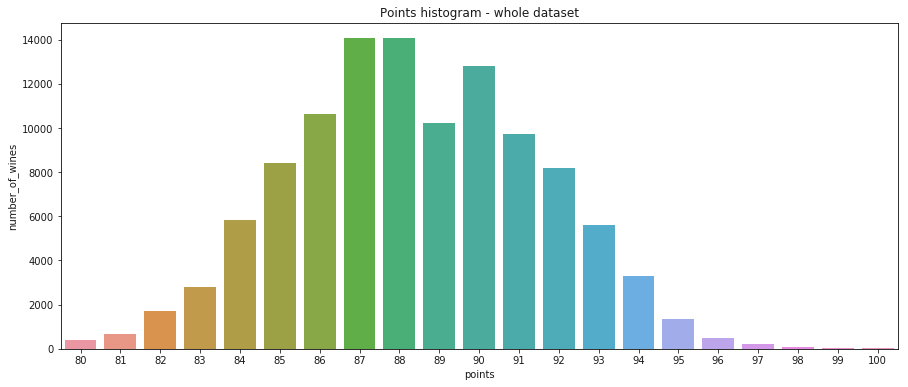

In [12]:
temp = data["points"].value_counts()
df = pd.DataFrame({'points': temp.index,
                   'number_of_wines': temp.values
                  })

pastel_plot(df,'points', 'number_of_wines')

Мы видим, что все вина имеют количество баллов выше 80. И точки имеют нормальное распределение. Наибольшее количество вин набрало 88 баллов.

Мы можем получить точное распределение не только по гистограмме. Покажем это в колонке цен

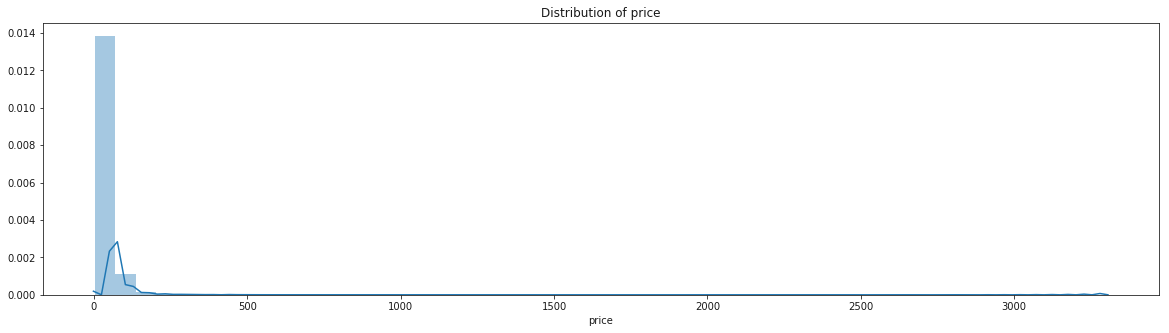

In [13]:
plt.figure(figsize=(20,5))
plt.title("Distribution of price")
ax = sns.distplot(data["price"])

Мы видим, что если мы хотим видеть лучшее распределение цен, мы должны увеличить нашу цену или отказаться значений, которые превышают 200 долларов. Также  подсчитаем, сколько вин стоят дороже 200 долларов.

There are : 0.589613043832123 % wines more expensive then 200 USD


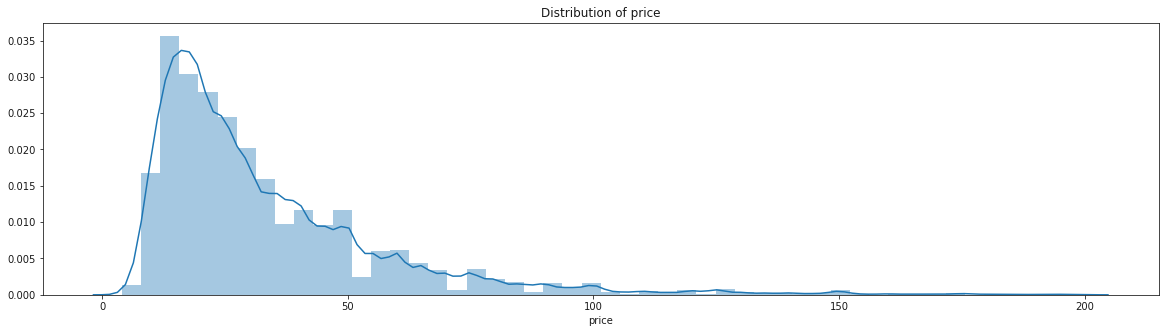

In [14]:
plt.figure(figsize=(20,5))
plt.title("Distribution of price")
ax = sns.distplot(data[data["price"]<200]['price'])

percent=data[data['price']>200].shape[0]/data.shape[0]*100
print("There are :", percent, "% wines more expensive then 200 USD")

Как мы видим, мы снизили цены только на 0,59 процента вин, и теперь мы видим, что распределение цен также нормальное. 

Давайте выясним, в какой стране самые дорогие и высокорейтинговые вина. Прежде всего, мы отсортируем его по цене, а затем построим график.

In [15]:
z=data.groupby(['country'])['price','points'].mean().reset_index().sort_values('price',ascending=False)
z[['country','price']].head(n=10)

,country,price
37,Switzerland,72.833333
13,England,52.677966
16,Germany,43.483325
18,Hungary,42.234375
14,France,41.593193
21,Italy,40.046586
39,US,36.757113
7,Canada,35.776786
2,Australia,35.358701
20,Israel,31.770419


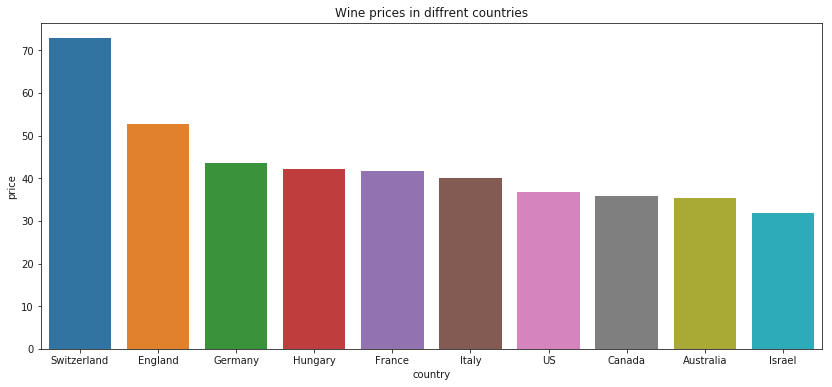

In [16]:
plt.figure(figsize = (14,6))
plt.title('Wine prices in diffrent countries')
sns.barplot(x = 'country', y="price", data=z.head(10))
locs, labels = plt.xticks()
plt.show()

In [17]:
z=z.sort_values('points', ascending=False)
z[['country','points']].head(10)

,country,points
13,England,91.762712
19,India,90.250000
3,Austria,90.223585
16,Germany,89.878912
7,Canada,89.312500
18,Hungary,89.265625
9,China,89.000000
23,Luxembourg,88.800000
14,France,88.739717
27,Morocco,88.708333


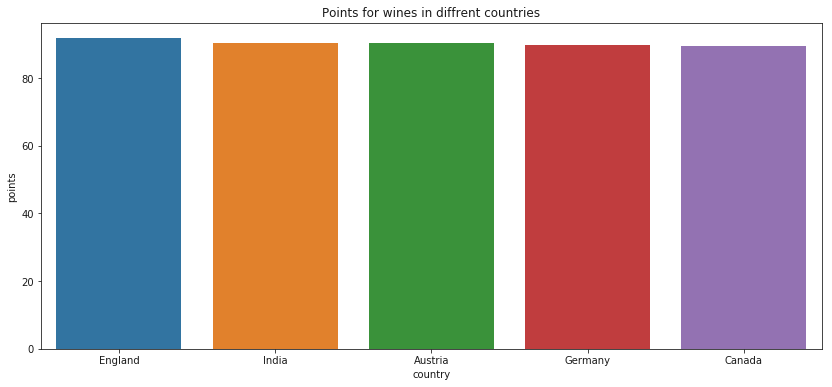

In [18]:
plt.figure(figsize = (14,6))
plt.title('Points for wines in diffrent countries')
sns.set_color_codes("pastel")
sns.barplot(x = 'country', y="points", data=z.head(5))
locs, labels = plt.xticks()
plt.show()

US              50011
France          15779
Italy           15391
Spain            5954
Portugal         4473
Chile            4124
Argentina        3500
Austria          2527
Australia        2155
Germany          1949
New Zealand      1238
South Africa     1195
Israel            453
Greece            424
Canada            224
Bulgaria          132
Hungary           128
Romania           101
Uruguay            98
Turkey             80
Name: country, dtype: int64

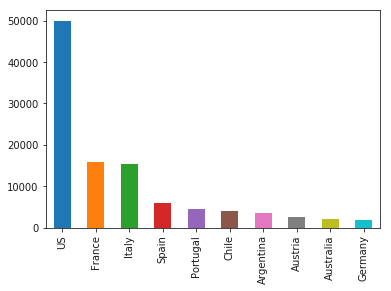

In [19]:
country=data['country'].value_counts()
country.head(10).plot.bar()
country.head(20)

Чтобы решить нашу "проблему", важным моментом для изучения будет также соотношение цены и качества.

In [20]:
z['quality/price']=z['points']/z['price']
z.sort_values('quality/price', ascending=False)[['country','quality/price']]

,country,quality/price
40,Ukraine,9.124031
4,Bosnia and Herzegovina,6.920000
19,India,6.563636
1,Armenia,6.034483
6,Bulgaria,5.921388
31,Romania,5.598587
24,Macedonia,5.552326
33,Slovakia,5.437500
11,Cyprus,5.278788
26,Moldova,5.208111


Также исследуем данные с помощью прямоугольных графиков.

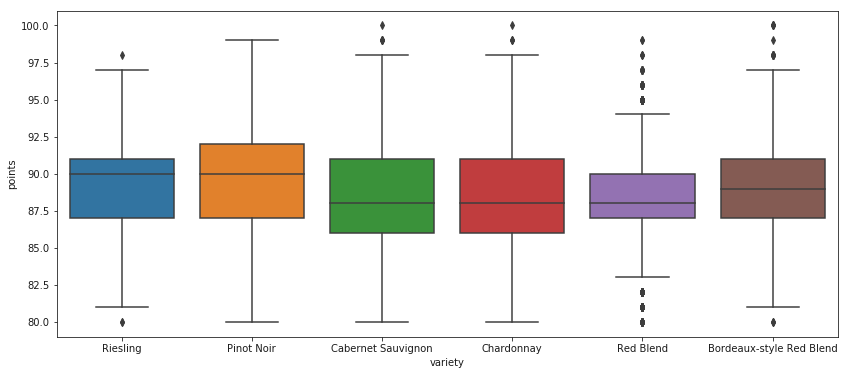

In [21]:
df1= data[data.variety.isin(data.variety.value_counts().head(6).index)]

plt.figure(figsize = (14,6))
sns.boxplot(
    x = 'variety',
    y = 'points',
    data = df1
)

Теперь мы хотим уменьшить размер нашего набора данных без потери точности модели.


Мы будем использовать одномерный выбор функций на основе важности функций из CatboostRegressor.

# # Важность признаков
Сначала мы подготовим наш train и тестовые данные. Мы будем использовать библиотеку sklearn.

In [22]:
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostRegressor, cv

X=data.drop(columns=['points'])

X=X.fillna(-1)
print(X.columns)
categorical_features_indices =[0,1, 3,4,5,6,7,8,9,10]
y=data['points']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, 
                                                    random_state=52)

Index(['country', 'designation', 'price', 'province', 'region_1', 'region_2',
       'taster_name', 'taster_twitter_handle', 'title', 'variety', 'winery'],
      dtype='object')


In [23]:
categorical_features_indices

[0, 1, 3, 4, 5, 6, 7, 8, 9, 10]

Создадим модель Catboostregressor с функцией потери среднеквадратичной ошибки.

In [24]:
def perform_model(X_train, y_train,X_valid, y_valid,X_test, y_test):
    model = CatBoostRegressor(
        random_seed = 400,
        loss_function = 'RMSE',
        iterations=400,
    )
    
    model.fit(
        X_train, y_train,
        cat_features = categorical_features_indices,
        eval_set=(X_valid, y_valid),
        verbose=False
    )
    
    print("RMSE on training data: "+ model.score(X_train, y_train).astype(str))
    print("RMSE on test data: "+ model.score(X_test, y_test).astype(str))
    
    return model
    

Запустим нашу модель и проверим результат.

In [25]:
model=perform_model(X_train, y_train,X_valid, y_valid,X_test, y_test)

RMSE on training data: 1.934471098716028
RMSE on test data: 2.0840347227841365


Теперь мы готовы создать feature importance plot. 

In [26]:
feature_score = pd.DataFrame(list(zip(X.dtypes.index, model.get_feature_importance(Pool(X, label=y, cat_features=categorical_features_indices)))),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')


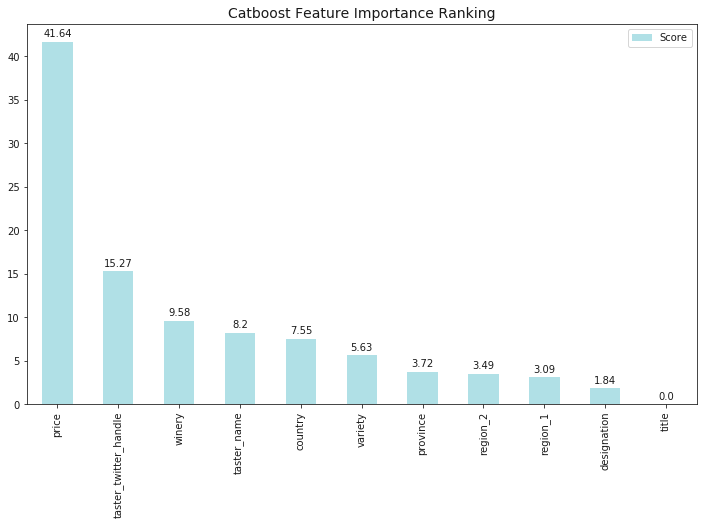

In [27]:
plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

Давайте попробуем отбросить 3 столбца, которые дают наименьшее количество информации.

In [28]:
X=data.drop(columns=['points','title', 'region_1'])
X=X.fillna(-1)

print(X.columns)
categorical_features_indices =[0,1,3,4,5,6,7,8]
y=data['points']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, 
                                                    random_state=52)

Index(['country', 'designation', 'price', 'province', 'region_2',
       'taster_name', 'taster_twitter_handle', 'variety', 'winery'],
      dtype='object')


А теперь выполним еще раз.

In [29]:
model=perform_model(X_train, y_train,X_valid, y_valid,X_test, y_test)

RMSE on training data: 1.9482227237961116
RMSE on test data: 2.0909409717344714


Как мы видим, наша модель работает лишь немного хуже, но мы экономим некоторое вычислительное время и оптимально используем оперативную память. Метод выбора объектов гораздо более полезен при работе с большим набором данных, где большое количество столбцов бесполезны.

Мы также можем увидеть, что самой важной характеристикой является цена. 